## Carrega bibliotecas necessárias

In [39]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

## Carrega a base e avalia a frequência de classes mativas

In [2]:
# Carrega a base e define os campos categóricos
dataset = pd.read_csv("../data/dataset_clean.csv")
campos_categoricos = [
    "Education", "Marital_Status", "Kidhome", "Teenhome"
]

# Para cada campo, registra uma tabela de frequência para
# categorias existentes, em ordem decrescente
frequencias = {}
for campo in campos_categoricos:
    categorias = set(dataset[campo].values)
    df = []
    
    for categoria in categorias:
        df.append({
            "categoria": categoria,
            "frequencia": list(dataset[campo].values).count(categoria)
        })
        
    frequencias[campo] = pd.DataFrame(df).sort_values("frequencia", ascending=False)
    
# Para cada campo, aplica regra de permanência, definida
# arbitrariamente para este projeto
para_remover = {}

for campo in frequencias.keys():
    total = sum([v for v in frequencias[campo]["frequencia"].values])
    frequencia_min = 0.8 / len(frequencias[campo])
    para_remover[campo] = []
    
    for i in range(0, len(frequencias[campo])):
        freq = frequencias[campo]["frequencia"].values[i]
        cat = frequencias[campo]["categoria"].values[i]
        
        if (freq / total) < frequencia_min:
            para_remover[campo].append(cat)
            
# Monta o dataset processado para treinamento
novo_dataset = []
for i in range(0, len(dataset)):
    valido = True
    
    for campo in campos_categoricos:
        valor = dataset[campo].values[i]
        if valor in para_remover[campo]:
            valido = False
            
    if valido:
        novo_dataset.append(dataset.values[i])
        
dataset = pd.DataFrame(novo_dataset, columns=dataset.columns)

## Aplica categorização para data de nascimento e renda

In [3]:
# Cria função para agrupamento de datas de nascimento
def encode_ano(ano: int):
    anos = [n for n in range(1940, 2010, 10)]
    
    for n in range(0, len(anos) - 1):
        if n == 0 and ano < anos[n]:
            return f"-{anos[n]}"
        elif ano >= anos[n] and ano < anos[n + 1]:
            return f"{anos[n]}-{anos[n + 1]}"
        elif n == len(anos) - 2 and ano >= anos[n + 1]:
            return f"+{anos[n + 1]}"
        

# Cria função para agrupamento de renda
def encode_renda(renda: float):
    rendas = [n for n in range(1000, 120000, 5000)]
    
    for n in range(0, len(rendas) - 1):
        if n == 0 and renda < rendas[n]:
            return f"-{rendas[n]}"
        elif renda >= rendas[n] and renda < rendas[n + 1]:
            return f"{rendas[n]}-{rendas[n + 1]}"
        elif n == len(rendas) - 2 and renda >= rendas[n + 1]:
            return f"+{rendas[n + 1]}"

In [4]:
# Cria colunas novas com as categorias artificiais
dataset.insert(0, "nascimento", [encode_ano(v) for v in dataset["Year_Birth"].values])
dataset.insert(1, "renda", [encode_renda(v) for v in dataset["Income"].values])

# Cria a instância para encoder das categorias
le_escolaridade = LabelEncoder()
v_ed = le_escolaridade.fit_transform(dataset["Education"].values)

le_estado_civil = LabelEncoder()
v_ec = le_estado_civil.fit_transform(dataset["Marital_Status"].values)

le_nascimento = LabelEncoder()
v_dn = le_nascimento.fit_transform(dataset["nascimento"].values)

le_renda = LabelEncoder()
v_rd = le_renda.fit_transform(dataset["renda"].values)

# Inclui as colunas categorizadas no dataset
dataset.insert(0, "encoder_escolaridade", v_ed)
dataset.insert(1, "encoder_estado_civil", v_ec)
dataset.insert(2, "encoder_nascimento", v_dn)
dataset.insert(3, "encoder_renda", v_rd)

## Agrupa os clientes e explica os grupos

### Resumo dos grupos

- Grupo 0: Married/Together + Graduation(+/-) + 0 crinaça + 1 adolescente + 1950-1970 + 46k-56k
- Grupo 1: Married + Graduation + 1 criança + 0 adolescente + 1970-1990 + 21k-31k
- Grupo 2: Together/Married + 1 criança (+/-) + 1 adolescente + 1950-1970 + 36k-46k
- Grupo 3: Married/Together + 0 criança + 1 adolescente (+/-) + 1950-1980 + 61k-71k
- Grupo 4: Married + 1 criança + 0 adolescente + 1970-1990 + 31k-41k# Separa a matriz de características para clientes
dados_clientes = dataset[[
    "encoder_escolaridade", "encoder_estado_civil", "encoder_nascimento",
    "encoder_renda", "Kidhome", "Teenhome"
]]

In [5]:
# Separa a matriz de características para clientes
dados_clientes = dataset[[
    "encoder_escolaridade", "encoder_estado_civil", "encoder_nascimento",
    "encoder_renda", "Kidhome", "Teenhome"
]]

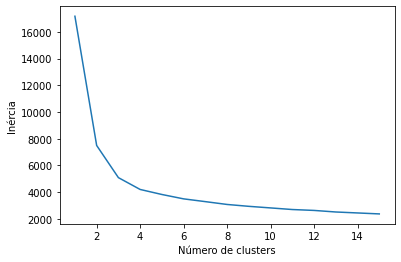

In [6]:
# Avaliza o número de clusters para encontrar a quantidade
# de grupos ideal
inercia = []
total = 16

for i in range(1, total):
    cluster = KMeans(n_clusters=i, random_state=0)
    cluster.fit(dados_clientes.values)
    inercia.append(cluster.inertia_)
    
plt.plot(range(1, total), inercia)
plt.xlabel("Número de clusters")
plt.ylabel("Inércia") 
plt.show()

In [7]:
# Treina o modelo de clusterização para clientes e encontra os grupos
model_clientes = KMeans(n_clusters=5, random_state=0)
model_clientes.fit(dados_clientes.values)
dataset.insert(0, "grupo_cliente", model_clientes.labels_)

# Encontra metadados para os grupos dados os campos definidos
metadados_grupos_clientes = []
campos = [
    "Education", "Marital_Status", "Kidhome", "Teenhome",
    "nascimento", "renda"
]

for grupo in set(model_clientes.labels_):
    subset = dataset.loc[dataset["grupo_cliente"] == grupo]
    
    for campo in campos:
        categorias = set(subset[campo].values)
        
        for categoria in categorias:
            metadados_grupos_clientes.append({
                "grupo": grupo,
                "campo": campo,
                "categoria": str(categoria),
                "observacoes": list(subset[campo].values).count(categoria)
            })
            
metadados_grupos_clientes = pd.DataFrame(metadados_grupos_clientes)

In [8]:
# Para cada grupo, faz a descrição da composição
for grupo in set(model_clientes.labels_):
    #print(f"AVALIANDO PARA O GRUPO {grupo}")
    
    subset = metadados_grupos_clientes.loc[metadados_grupos_clientes["grupo"] == grupo]
    for campo in set(subset["campo"].values):
        #print(f"\nDistribuição para {campo}")
        
        temp = subset.loc[subset["campo"] == campo]
        total_observacoes = sum(temp["observacoes"].values)
        
        for i in range(0, len(temp)):
            categoria = temp["categoria"].values[i]
            observacoes = temp["observacoes"].values[i]
            
            #print(f"{categoria}: {observacoes * 100 / total_observacoes}")
            
    #print("===================================\n")

## Encontra a preferência de produtos para cada grupo de cliente

In [36]:
campos = [
    "MntWines", "MntFruits", "MntMeatProducts",
    "MntFishProducts", "MntSweetProducts", "MntGoldProds"
]

for grupo in set(model_clientes.labels_):
    subset = dataset.loc[dataset["grupo_cliente"] == grupo]
    
    total = 0
    produtos = {}
    for campo in campos:
        total_produto = sum(subset[campo].values)
        produtos[campo] = total_produto
        total = total + total_produto
        
    print(f"Para o grupo {grupo}, as preferências de produtos são:")
    for campo in campos:
        print(f"{campo}: {produtos[campo] * 100 / total}")
    print("")

Para o grupo 0, as preferências de produtos são:
MntWines: 64.68010355029585
MntFruits: 2.518491124260355
MntMeatProducts: 18.15735946745562
MntFishProducts: 3.7934541420118344
MntSweetProducts: 2.6072485207100593
MntGoldProds: 8.243343195266272

Para o grupo 1, as preferências de produtos são:
MntWines: 28.137801356524076
MntFruits: 7.158686454905648
MntMeatProducts: 28.507151970989188
MntFishProducts: 10.09334497347391
MntSweetProducts: 6.433416157410516
MntGoldProds: 19.669599086696664

Para o grupo 2, as preferências de produtos são:
MntWines: 55.29485752987277
MntFruits: 3.5411929756663927
MntMeatProducts: 21.392288713656814
MntFishProducts: 4.489381258768323
MntSweetProducts: 3.1686904358763486
MntGoldProds: 12.113589086159354

Para o grupo 3, as preferências de produtos são:
MntWines: 62.4952467868279
MntFruits: 2.5439196897102443
MntMeatProducts: 23.769868431059397
MntFishProducts: 4.188259835077083
MntSweetProducts: 2.801408037547668
MntGoldProds: 4.201297219777713

Para o gru

## Encontra a preferência de método de compra para cada grupo

In [37]:
campos = [
    "NumDealsPurchases", "NumWebPurchases",
    "NumCatalogPurchases", "NumStorePurchases"
]

for grupo in set(model_clientes.labels_):
    subset = dataset.loc[dataset["grupo_cliente"] == grupo]
    
    total = 0
    compras = {}
    for campo in campos:
        total_compra = sum(subset[campo].values)
        compras[campo] = total_compra
        total = total + total_compra
        
    print(f"Para o grupo {grupo}, as preferências de compra são:")
    for campo in campos:
        print(f"{campo}: {compras[campo] * 100 / total}")
    print("")

Para o grupo 0, as preferências de compra são:
NumDealsPurchases: 18.79661859771258
NumWebPurchases: 29.38836399801094
NumCatalogPurchases: 13.326703132769767
NumStorePurchases: 38.48831427150672

Para o grupo 1, as preferências de compra são:
NumDealsPurchases: 26.599113362887906
NumWebPurchases: 26.535782140595312
NumCatalogPurchases: 5.00316656111463
NumStorePurchases: 41.86193793540215

Para o grupo 2, as preferências de compra são:
NumDealsPurchases: 25.967628430682616
NumWebPurchases: 26.460239268121043
NumCatalogPurchases: 8.304011259676285
NumStorePurchases: 39.268121041520054

Para o grupo 3, as preferências de compra são:
NumDealsPurchases: 9.486663311524913
NumWebPurchases: 27.70508303975843
NumCatalogPurchases: 20.306995470558633
NumStorePurchases: 42.501258178158025

Para o grupo 4, as preferências de compra são:
NumDealsPurchases: 23.52112676056338
NumWebPurchases: 30.093896713615024
NumCatalogPurchases: 7.511737089201878
NumStorePurchases: 38.87323943661972



## Verifica qual grupo é mais receptível à campanha

In [38]:
for grupo in set(model_clientes.labels_):
    subset = dataset.loc[dataset["grupo_cliente"] == grupo]
    total_aceites = sum(subset["Response"].values)
    
    print(f"Para o grupo {grupo}, a tendência de aceitar as campanhas é:")
    print(f"Total registros: {len(subset)}")
    print(f"Total aceites: {total_aceites} ou {total_aceites * 100 / len(subset)}%")
    print("")

Para o grupo 0, a tendência de aceitar as campanhas é:
Total registros: 265
Total aceites: 23 ou 8.679245283018869%

Para o grupo 1, a tendência de aceitar as campanhas é:
Total registros: 223
Total aceites: 26 ou 11.659192825112108%

Para o grupo 2, a tendência de aceitar as campanhas é:
Total registros: 155
Total aceites: 13 ou 8.387096774193548%

Para o grupo 3, a tendência de aceitar as campanhas é:
Total registros: 197
Total aceites: 27 ou 13.705583756345177%

Para o grupo 4, a tendência de aceitar as campanhas é:
Total registros: 230
Total aceites: 31 ou 13.478260869565217%



## Persiste todos os modelos

In [41]:
# Salva modelo de clusterização de clientes
file = open("../models/model_clientes.pickle", "wb")
pickle.dump(model_clientes, file)
file.close()

# Salva encoder para escolaridade
file = open("../models/encoder_escolaridade.pickle", "wb")
pickle.dump(le_escolaridade, file)
file.close()

# Salva encoder para estado civil
file = open("../models/encoder_estado_civil.pickle", "wb")
pickle.dump(le_estado_civil, file)
file.close()

# Salva encoder para data de nascimento
file = open("../models/encoder_data_nascimento.pickle", "wb")
pickle.dump(le_nascimento, file)
file.close()

# Salva encoder para renda
file = open("../models/encoder_renda.pickle", "wb")
pickle.dump(le_renda, file)
file.close()